In [0]:
!pip install pytesseract
!pip install tesseract
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import drive
import numpy as np
import re

import tensorflow as tf
import pickle

drive.mount('/content/drive')
IMG_PATH = "/content/drive/My Drive/CSC480CharNN/MultilineTest/"
pytesseract.pytesseract.tesseract_cmd = '/usr/local/Cellar/tesseract/4.1.0/bin/tesseract'

def sortContours(contours):
  myContours = []
  # Process the raw contours to get bounding rectangles
  for cnt in reversed(contours):
      epsilon = 0.1*cv2.arcLength(cnt,True)
      approx = cv2.approxPolyDP(cnt,epsilon,True)
      if len(approx == 4):
          rectangle = cv2.boundingRect(cnt)
          myContours.append(rectangle)
  max_width = max(myContours, key=lambda r: r[0] + r[2])[0]
  max_height = max(myContours, key=lambda r: r[3])[3]
  nearest = max_height * 1.4
  myContours.sort(key=lambda r: (int(nearest * round(float(r[1])/nearest)) * max_width + r[0]))
  return myContours

def getCharImages(img):
  th, im_th = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY_INV);
 
  # Copy the thresholded image.
  im_floodfill = im_th.copy()
  
  # Mask used to flood filling.
  # Notice the size needs to be 2 pixels than the image.
  h, w = im_th.shape[:2]
  mask = np.zeros((h+2, w+2), np.uint8)
  
  # Floodfill from point (0, 0)
  cv2.floodFill(im_floodfill, mask, (0,0), 255);
  
  # Invert floodfilled image
  im_floodfill_inv = cv2.bitwise_not(im_floodfill)
  
  # Combine the two images to get the foreground.
  im_out = im_th | im_floodfill_inv
  gray = cv2.cvtColor(im_out, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

  ctrs, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  final = []
  sortedCtrs = sortContours(ctrs)
  for ctr in sortedCtrs:
      x, y, w, h = ctr
      x = x - 5
      y = y - 10
      ROI = img[y:y + h + 15, x:x + w + 10]
      area = w * h
      if 20 < area:
        final.append(ROI)
  return final


  Created wheel for pytesseract: filename=pytesseract-0.3.0-py2.py3-none-any.whl size=20970 sha256=84459fe137b2b45645ec33dc820eea310dedb652d6d2dd851d593bbbfab211ab
  Stored in directory: /root/.cache/pip/wheels/78/c9/ac/4cb76bd547f9970070522439e5203ba7926c5c5c4f131583ea
Successfully built pytesseract
     |████████████████████████████████| 45.6MB 49kB/s 
  Created wheel for tesseract: filename=tesseract-0.1.3-cp36-none-any.whl size=45562572 sha256=6a00b921e4613bef9e38fde1d0872c1d5e9f749189729348c50ab92e1704876f
  Stored in directory: /root/.cache/pip/wheels/82/1f/d9/24797b123379e4ea9511cf660835468b62dad609634cad2aba
Successfully built tesseract


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def getWordImages(filename):
  img = cv2.imread(IMG_PATH + filename)

  th, im_th = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY_INV);
 
  # Copy the thresholded image.
  im_floodfill = im_th.copy()
  
  # Mask used to flood filling.
  # Notice the size needs to be 2 pixels than the image.
  h, w = im_th.shape[:2]
  mask = np.zeros((h+2, w+2), np.uint8)
  
  # Floodfill from point (0, 0)
  cv2.floodFill(im_floodfill, mask, (0,0), 255);
  
  # Invert floodfilled image
  im_floodfill_inv = cv2.bitwise_not(im_floodfill)
  
  # Combine the two images to get the foreground.
  im_out = im_th | im_floodfill_inv
  gray = cv2.cvtColor(im_out, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

  #dilation
  #this is responsible for breaking the text into words
  kernel = np.ones((10,40), np.uint8)
  img_dilation = cv2.dilate(thresh, kernel, iterations=1)
  cv2_imshow(img_dilation) 

  ctrs, hier= cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  final = []
  lenOfWords = []
  sortedCtrs = sortContours(ctrs)
  for ctr in sortedCtrs:
      x,y,w,h = ctr
      ROI = img[y:y+h, x:x+w]
      l = getCharImages(ROI)
      lenOfWords.append(len(l))
      final.append(l)
  return lenOfWords

In [0]:
IMG_SIZE = 32

#Load prediction model
new_model = tf.keras.models.load_model('/content/drive/My Drive/CSC480CharNN/char_reader.model')

#Load array with categories
pickle_in = open("/content/drive/My Drive/CSC480CharNN/CATEGORIES.pickle", "rb")
CATEGORIES = pickle.load(pickle_in)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def process_image(image_array):  

  image_array = image_array[:,:,-1]

  image_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE)) 

  image_array = image_array[np.newaxis,:,:,np.newaxis]

  #Invert colors to match training input images
  image_array[0,:,:,-1] = np.invert(image_array[0,:,:,-1])

  #Normalize data
  image_array = tf.keras.utils.normalize(image_array, axis=1) 

  plt.imshow(image_array[-1,:,:,-1]) 
  plt.show()
  
  return image_array

In [0]:
def get_prediction(image_array):
  pred_distribution = new_model.predict(image_array)
  prediction = CATEGORIES[np.argmax(pred_distribution[0])]
  return pred_distribution, prediction

In [0]:
def get_probability(pred):
  percentage = []
  top5 = np.argsort(pred[0])[::-1][:5]
  for i in range(len(top5)):
    prob = pred[0][top5[i]]
    total = np.sum(pred[0])
    percentage = prob/total * 100
    print(round(percentage, 2), "% - ", CATEGORIES[top5[i]])

In [0]:
def insert_space(string, integer):
    return string[0:integer] + ' ' + string[integer:]

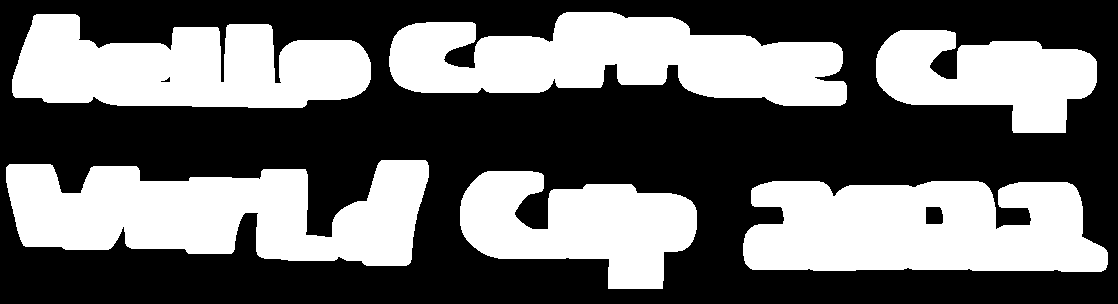

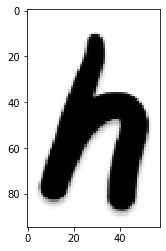

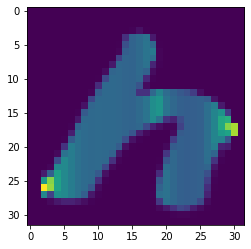

61.07 % -  H
6.42 % -  K
5.26 % -  M
3.65 % -  N
3.65 % -  B


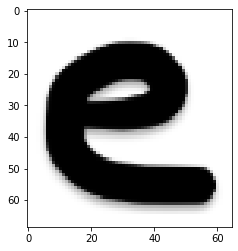

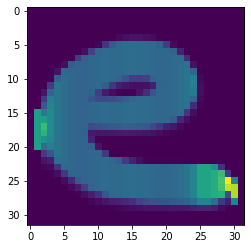

49.44 % -  E
9.75 % -  Z
8.42 % -  C
7.25 % -  Q
5.36 % -  P


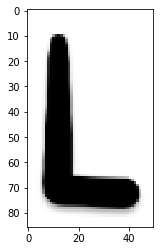

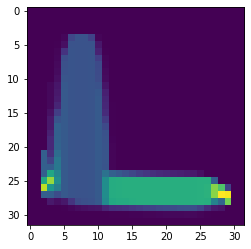

33.46 % -  L
20.14 % -  K
14.01 % -  Z
6.04 % -  C
5.59 % -  T


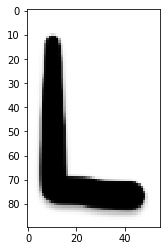

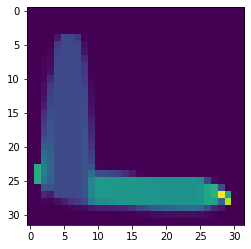

33.37 % -  L
18.94 % -  C
13.7 % -  Z
10.5 % -  K
4.38 % -  T


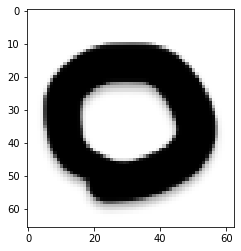

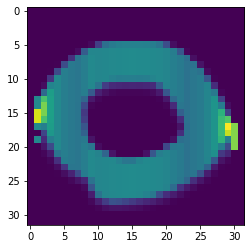

28.19 % -  O
11.93 % -  C
10.24 % -  A
8.78 % -  G
6.83 % -  E


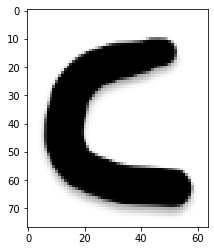

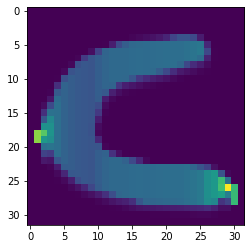

33.59 % -  C
15.95 % -  Z
8.44 % -  T
7.02 % -  E
6.92 % -  K


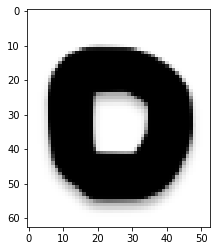

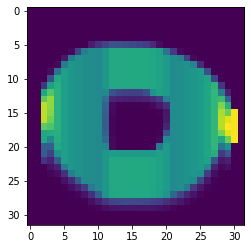

28.42 % -  O
8.97 % -  E
8.57 % -  A
7.1 % -  G
6.23 % -  C


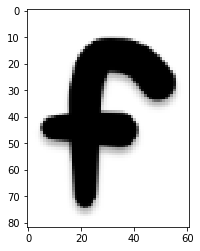

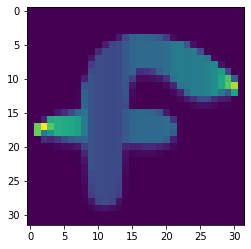

48.69 % -  F
33.35 % -  T
7.39 % -  J
2.48 % -  S
1.87 % -  5


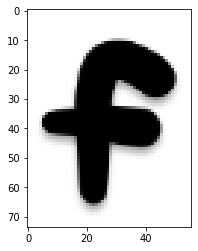

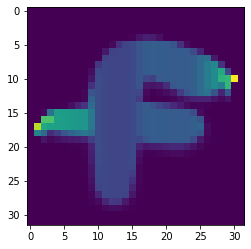

39.93 % -  F
26.04 % -  T
15.62 % -  J
5.62 % -  4
1.82 % -  R


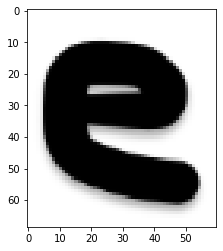

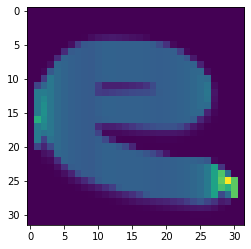

36.1 % -  E
13.92 % -  Q
11.44 % -  Z
7.73 % -  P
5.73 % -  G


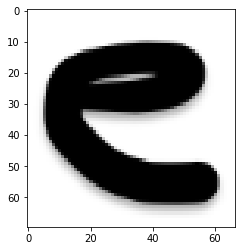

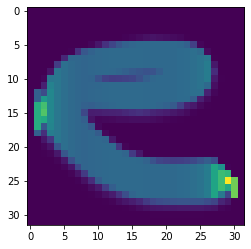

38.18 % -  E
11.2 % -  C
10.0 % -  Z
8.83 % -  P
6.88 % -  Q


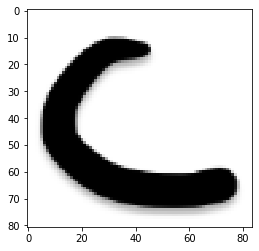

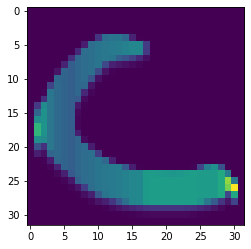

49.12 % -  C
10.04 % -  L
9.47 % -  Z
4.77 % -  6
4.74 % -  K


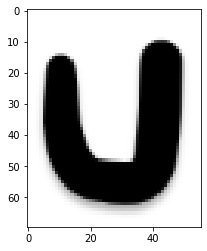

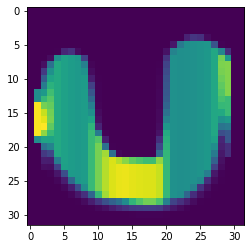

19.7 % -  U
18.25 % -  V
17.66 % -  J
5.73 % -  W
4.62 % -  4


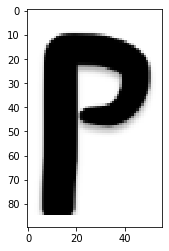

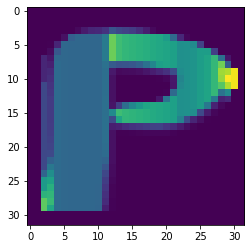

44.04 % -  P
27.3 % -  F
5.53 % -  E
5.31 % -  9
3.69 % -  8


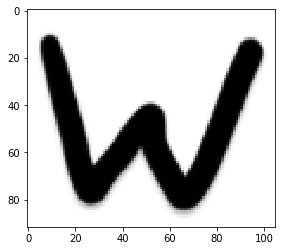

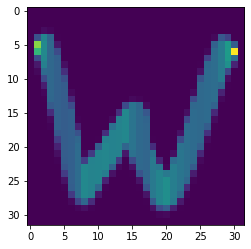

62.04 % -  W
11.88 % -  H
7.39 % -  V
4.77 % -  U
3.51 % -  1


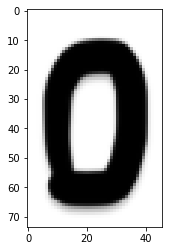

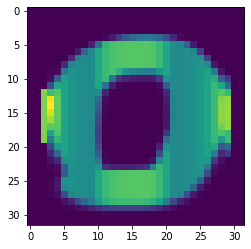

23.05 % -  O
8.82 % -  A
8.75 % -  C
8.58 % -  G
7.23 % -  Q


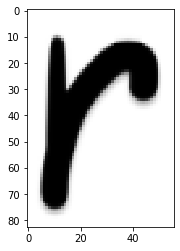

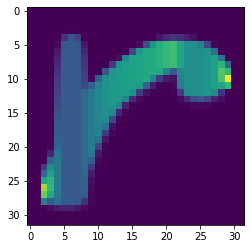

36.0 % -  R
23.74 % -  P
11.62 % -  F
5.55 % -  V
4.47 % -  Y


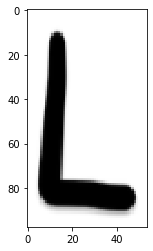

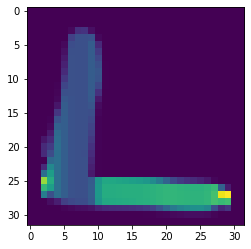

37.86 % -  L
14.16 % -  C
9.92 % -  Z
8.65 % -  K
6.72 % -  T


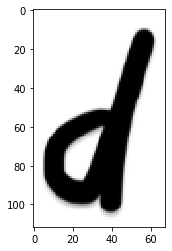

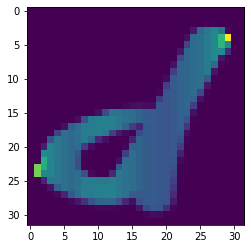

51.34 % -  D
30.9 % -  J
4.0 % -  2
2.13 % -  T
1.89 % -  6


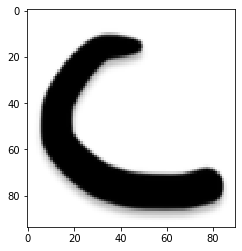

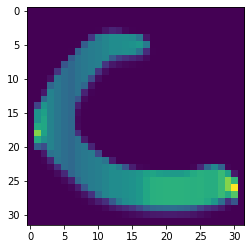

48.73 % -  C
12.04 % -  L
7.79 % -  Z
5.14 % -  6
4.86 % -  K


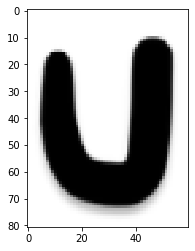

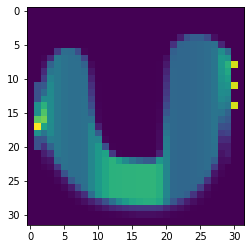

20.22 % -  U
17.34 % -  V
14.25 % -  J
5.84 % -  W
4.8 % -  4


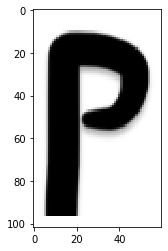

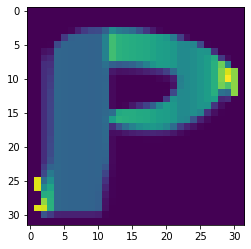

46.03 % -  P
25.61 % -  F
5.79 % -  E
5.07 % -  9
2.75 % -  8


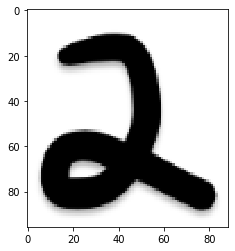

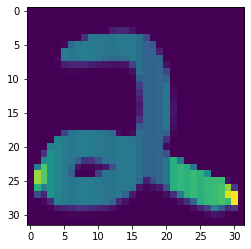

51.92 % -  2
18.98 % -  Z
10.74 % -  D
3.97 % -  J
3.64 % -  A


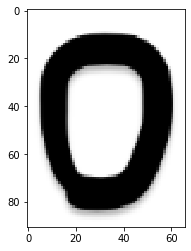

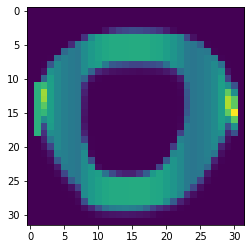

29.47 % -  O
12.84 % -  C
8.1 % -  Q
7.39 % -  G
5.88 % -  J


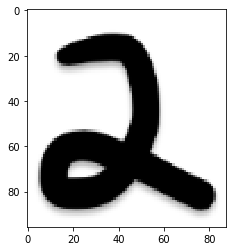

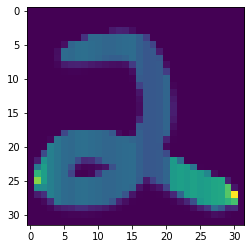

51.81 % -  2
19.36 % -  Z
10.31 % -  D
4.09 % -  J
3.61 % -  A


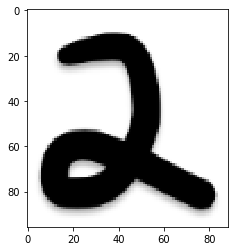

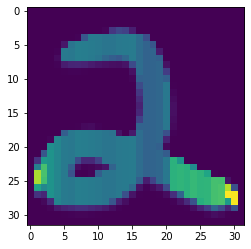

51.86 % -  2
19.15 % -  Z
11.19 % -  D
3.59 % -  J
3.37 % -  A

Image 0 details
list  [5, 6, 3, 5, 3, 4]
Actual Word:  hello coffee cup WORLD CUP 2022
Word predicted:  HELLO COFFEE CUP WORLD CUP 2O22 

----------------------------------------------------------------------------------------------------------------------------------------



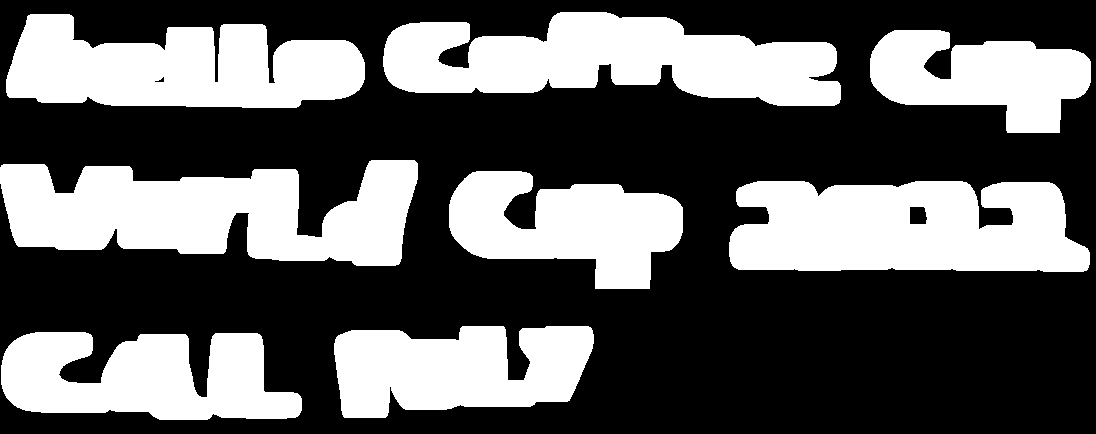

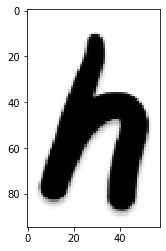

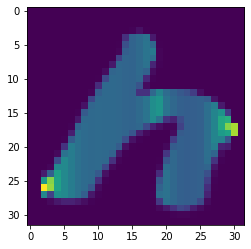

61.07 % -  H
6.42 % -  K
5.26 % -  M
3.65 % -  N
3.65 % -  B


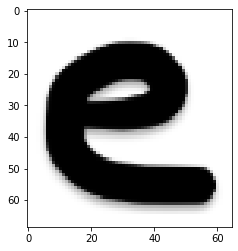

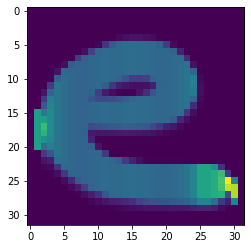

49.44 % -  E
9.75 % -  Z
8.42 % -  C
7.25 % -  Q
5.36 % -  P


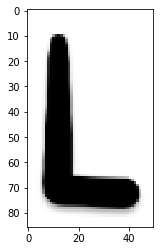

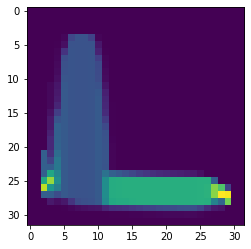

33.46 % -  L
20.14 % -  K
14.01 % -  Z
6.04 % -  C
5.59 % -  T


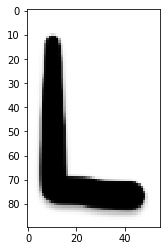

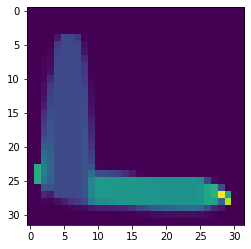

33.37 % -  L
18.94 % -  C
13.7 % -  Z
10.5 % -  K
4.38 % -  T


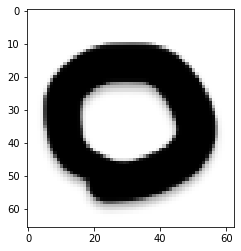

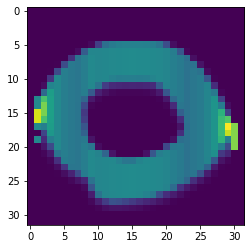

28.19 % -  O
11.93 % -  C
10.24 % -  A
8.78 % -  G
6.83 % -  E


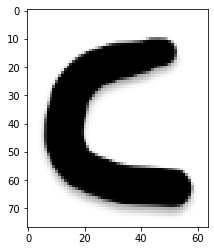

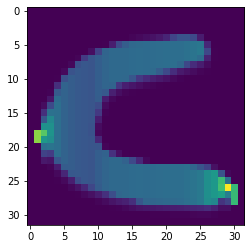

33.59 % -  C
15.95 % -  Z
8.44 % -  T
7.02 % -  E
6.92 % -  K


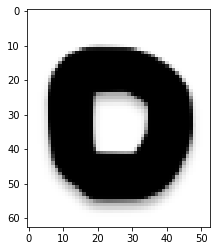

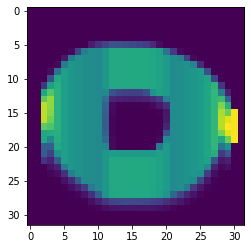

28.42 % -  O
8.97 % -  E
8.57 % -  A
7.1 % -  G
6.23 % -  C


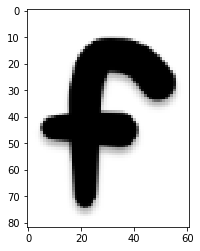

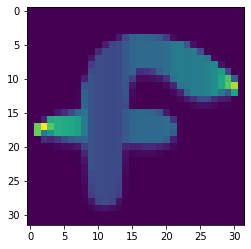

48.69 % -  F
33.35 % -  T
7.39 % -  J
2.48 % -  S
1.87 % -  5


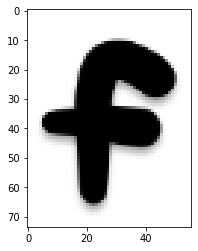

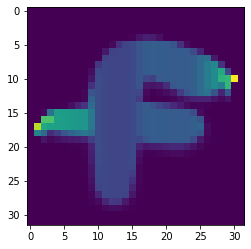

39.93 % -  F
26.04 % -  T
15.62 % -  J
5.62 % -  4
1.82 % -  R


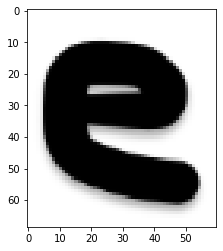

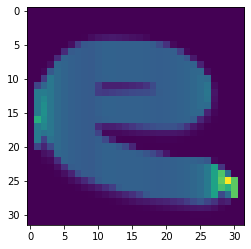

36.1 % -  E
13.92 % -  Q
11.44 % -  Z
7.73 % -  P
5.73 % -  G


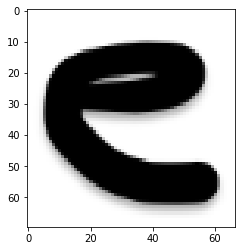

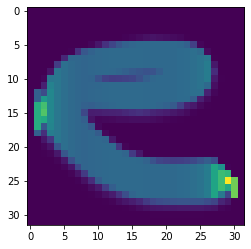

38.18 % -  E
11.2 % -  C
10.0 % -  Z
8.83 % -  P
6.88 % -  Q


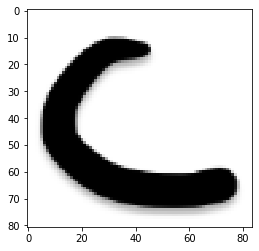

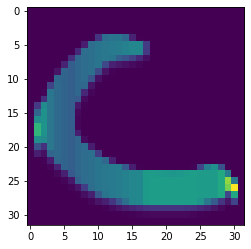

49.12 % -  C
10.04 % -  L
9.47 % -  Z
4.77 % -  6
4.74 % -  K


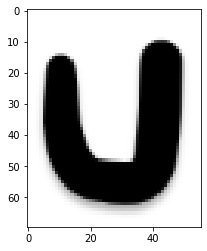

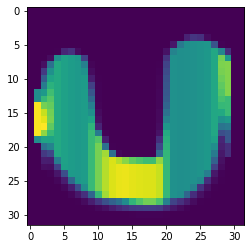

19.7 % -  U
18.25 % -  V
17.66 % -  J
5.73 % -  W
4.62 % -  4


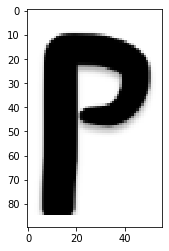

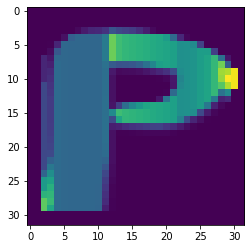

44.04 % -  P
27.3 % -  F
5.53 % -  E
5.31 % -  9
3.69 % -  8


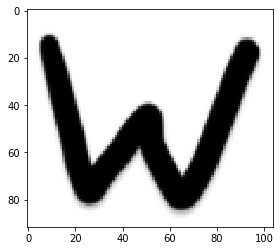

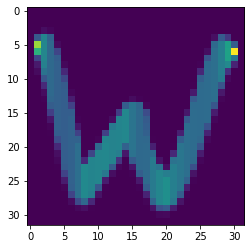

62.63 % -  W
11.04 % -  H
7.31 % -  V
4.93 % -  U
3.54 % -  1


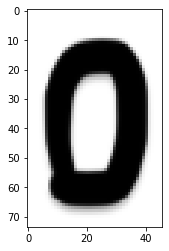

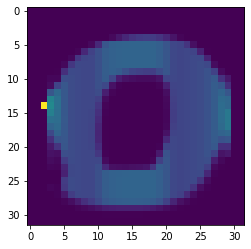

18.58 % -  O
10.72 % -  J
7.98 % -  C
7.22 % -  G
6.21 % -  A


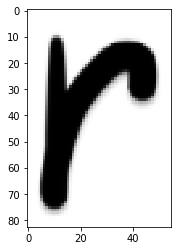

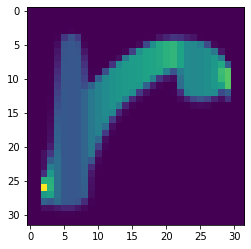

35.87 % -  R
23.69 % -  P
11.81 % -  F
5.3 % -  V
4.77 % -  Y


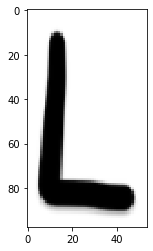

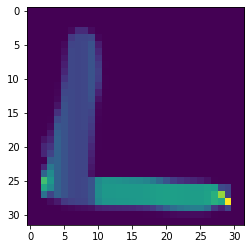

37.67 % -  L
14.17 % -  C
9.56 % -  Z
8.48 % -  K
6.71 % -  T


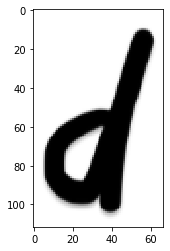

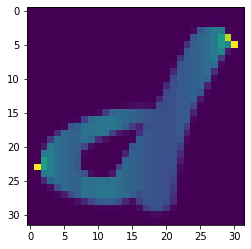

52.84 % -  D
29.2 % -  J
4.02 % -  2
2.27 % -  6
1.96 % -  T


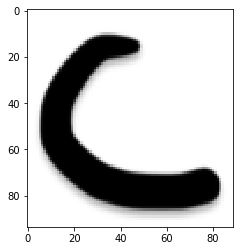

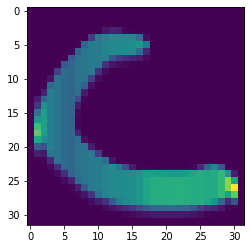

48.6 % -  C
12.16 % -  L
7.93 % -  Z
5.07 % -  6
4.67 % -  K


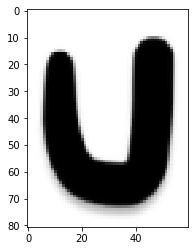

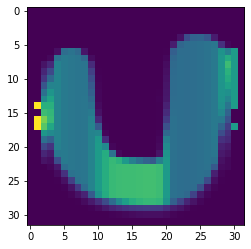

18.12 % -  U
17.39 % -  V
14.53 % -  J
6.38 % -  4
5.68 % -  W


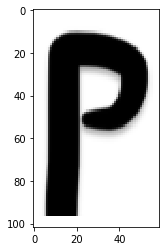

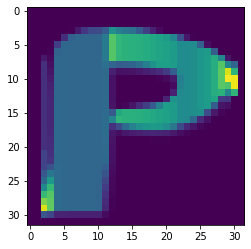

46.16 % -  P
26.25 % -  F
5.23 % -  9
4.45 % -  E
2.72 % -  8


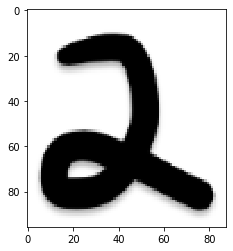

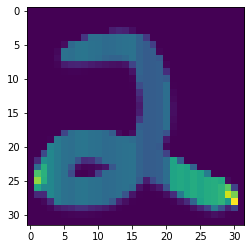

52.03 % -  2
19.08 % -  Z
10.69 % -  D
3.88 % -  J
3.51 % -  A


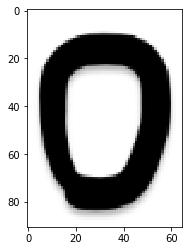

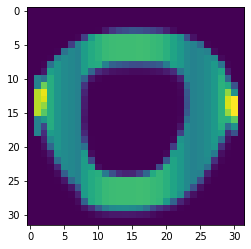

29.74 % -  O
13.23 % -  C
7.87 % -  Q
7.61 % -  G
5.75 % -  J


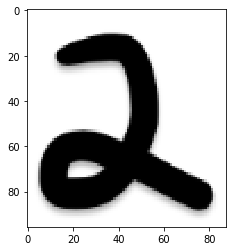

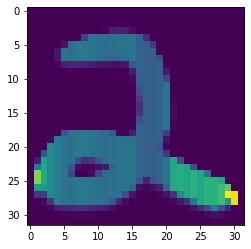

51.47 % -  2
19.74 % -  Z
10.57 % -  D
3.69 % -  J
3.48 % -  A


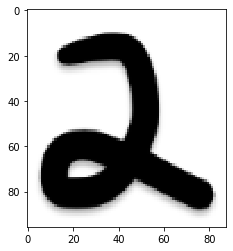

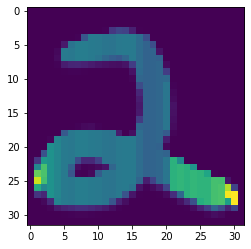

52.17 % -  2
18.99 % -  Z
11.08 % -  D
3.6 % -  J
3.32 % -  A


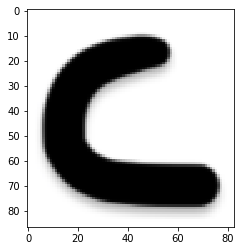

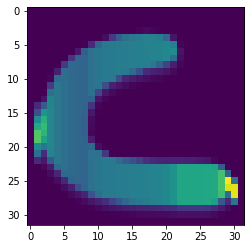

33.66 % -  C
14.44 % -  Z
10.26 % -  T
7.86 % -  K
3.92 % -  E


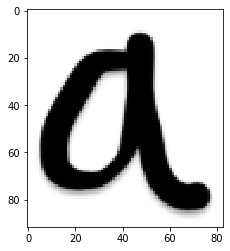

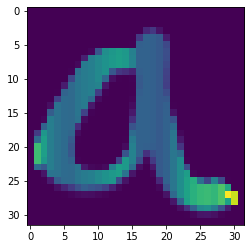

38.31 % -  A
10.67 % -  U
9.37 % -  2
8.37 % -  Q
7.91 % -  G


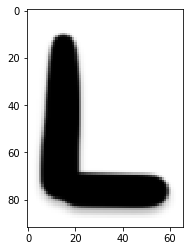

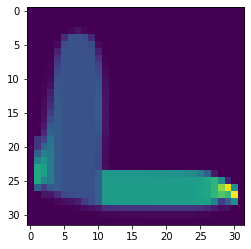

37.16 % -  L
13.93 % -  K
12.93 % -  Z
8.45 % -  C
5.87 % -  T


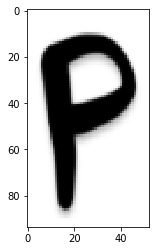

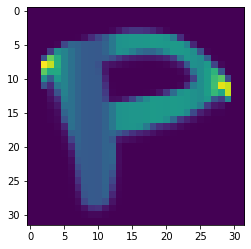

58.61 % -  P
23.2 % -  F
5.8 % -  R
3.36 % -  9
2.68 % -  8


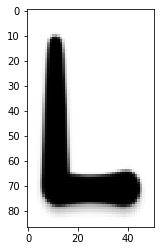

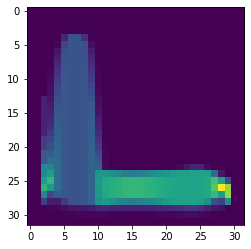

36.47 % -  L
14.27 % -  K
12.4 % -  Z
9.76 % -  C
6.94 % -  T


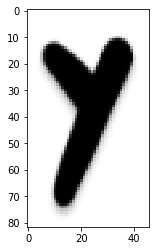

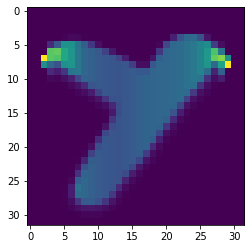

26.02 % -  J
25.64 % -  Y
12.95 % -  7
12.74 % -  X
6.79 % -  V


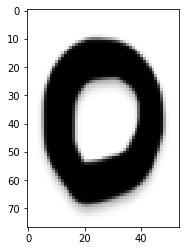

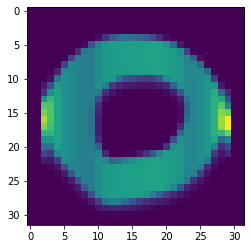

34.37 % -  O
11.44 % -  C
7.2 % -  E
6.75 % -  A
6.24 % -  Q

Image 1 details
list  [5, 6, 3, 5, 3, 4, 3, 4]
Actual Word:  hello coffee cup WORLD CUP 2022 cal poly
Word predicted:  HELLO COFFEE CUP WORLD CUP 2O22 CAL PLJO 

----------------------------------------------------------------------------------------------------------------------------------------



In [0]:
if __name__ == "__main__":

  actual_word = ["hello coffee cup WORLD CUP 2022", "hello coffee cup WORLD CUP 2022 cal poly" ]
  image_name = ["test10.jpg", "test5.jpg"]
  #test5.jpg is the closest prediction for all 
  #test10.jpg is 100% accurate

  for j in range(len(image_name)):
      img = cv2.imread(IMG_PATH + image_name[j])
      image_array = getCharImages(img)

      word_length = getWordImages(image_name[j])

      new_image_array = []
      predicted_word = ""

      for i in range(len(image_array)):
        plt.imshow(image_array[i][:,:]) 
        plt.show()

        new_image_array = (process_image(image_array[i]))
        pred_distribution, prediction = get_prediction(new_image_array)

        predicted_word = predicted_word + prediction
        get_probability(pred_distribution)

      new_string = ""
      start = 0
      for k in word_length:
        new_string += predicted_word[start:start+k] + " " 
        start+=k
      print("\nImage " + str(j) + " details")
      print ("list ", word_length)
      print("Actual Word: ", actual_word[j])
      print("Word predicted: ", new_string)
      print("\n----------------------------------------------------------------------------------------------------------------------------------------\n")
      
